# COMP90051 Workshop 9
## Gaussian mixture models
***
In this worksheet we explore Gaussian mixture models (GMM). By the end of the worksheet, you should be able to:
* explain the underlying model for a GMM;
* fit GMMs using `sklearn`; and
* select an appropriate value for the number of clusters.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from numpy.random import multivariate_normal

### 1. Sampling from a Gaussian mixture

Consider a data set $\{\mathbf{x}_1, \ldots, \mathbf{x}_n\}$ (each $\mathbf{x}_i \in \mathbb{R}^m$) which we'd like to partition into clusters.

A Gaussian mixture model (GMM) assumes that each instance $\mathbf{x}_i$ is distributed according to a weighted mixture of multivariate normal distributions (Gaussians):
$$
\mathbf{x}_i \overset{\mathrm{iid}}{\sim} \sum_{c = 1}^{k} w_c \mathcal{N}(\mathbf{\mu}_c, \mathbf{\Sigma}_c)
$$
where $\mathbf{\mu}_c \in \mathbb{R}_m$ and $\mathbf{\Sigma}_c \in \mathbb{R}^{m \times m}$ are the mean and covariance matrix for component $c$ and $\sum_{c = 1}^{k} w_c = 1$.

In this section, we'll write a function to generate a synthetic data set for a given set of GMM parameters.
Later on, we'll try to fit a GMM to the synthetic data set and see how well we can recover the parameters.

We'll store the GMM parameters in NumPy arrays as follows. Note: the zero-th axis indexes the component $c$ for all arrays.
* `weights`: a 1D array $[w_1, \ldots, w_k]$
* `means`: a 2D array $[\mathbf{\mu}_1, \ldots, \mathbf{\mu}_k]$
* `covariances`: a 3D array $[\mathbf{\Sigma}_1, \ldots, \mathbf{\Sigma}_k]$

Below are some example parameters for a 2D feature space ($m = 2$) with $k = 3$ components. Note that the covariance matrices must be symmetric positive semi-definite. Thus each covariance matrix only has 3 degrees of freedom (for $m = 2$).

In [2]:
weights = np.array([0.5, 0.3, 0.2])

means = np.array([[0, 0],    # mean of 1st component
                  [50, 60],  # mean of 2nd component
                  [0, 100]]) # mean of 3rd component

covariances = np.array([[[160, 20], [20, 180]],  # covariance matrix of 1st component
                        [[170, 30], [30, 120]],  # covariance matrix of 2nd component 
                        [[130, 40], [40, 130]]]) # covariance matrix of 3rd component

Complete the data generation function below.

In [3]:


def generate_gmm_data(n_instances, weights, means, covariances, debug=False):
    """
    Generate data from a GMM
    
    Arguments
    =========
    n_instances : int
        number of instances in the generated data set
    weights : numpy array, shape: (n_components,)
        normalised component weights
    means : numpy array, shape (n_components, n_features)
        component means
    covariances : numpy array, shape (n_components, n_features, n_features)
        component covariance matrices
    
    Returns
    =======
    numpy array, shape (n_instances, n_features)
        data matrix
    """
    n_components, n_features = means.shape
    data = np.empty((0, n_features), dtype=np.double)
    
    # Draw number of instances in each component
    counts = np.random.multinomial(n_instances, weights)
    
    for c in range(0, n_components):
        # Debugging info
        if debug:
            print('--- Component c={} ---'.format(c+1))
            print('Mean: {}'.format(means[c]))
            print('Covariance matrix:\n {}'.format(covariances[c]))
            print('Appending {} samples\n'.format(counts[c]))
        
        # Draw x_i's for this component
        # cData = weights[c] * multivariate_normal(means[c], covariances[c])
        cData = weights[c] * np.random.multivariate_normal(means[c], covariances[c], counts[c])
        
        # Append to data
        data = np.vstack((data, cData))
    
    return data

In [4]:
np.random.multinomial(10, weights)

array([5, 2, 3])

Let's try it out (setting $n = 100$).

--- Component c=1 ---
Mean: [0 0]
Covariance matrix:
 [[160  20]
 [ 20 180]]
Appending 52 samples

--- Component c=2 ---
Mean: [50 60]
Covariance matrix:
 [[170  30]
 [ 30 120]]
Appending 29 samples

--- Component c=3 ---
Mean: [  0 100]
Covariance matrix:
 [[130  40]
 [ 40 130]]
Appending 19 samples



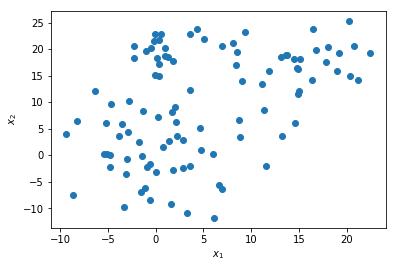

In [5]:
data = generate_gmm_data(100, weights, means, covariances, debug=True)

plt.scatter(data[:,0], data[:,1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

### 2. Fitting a GMM

Let's fit a Gaussian mixture model (GMM) to the synthetic data we've just generated.
We'll use the built-in implementation in sklearn available at `sklearn.mixture.GaussianMixture`. 
The fitting procedure implements the Expectation Maximisation algorithm covered in lectures.

We have to specify the number of clusters $k$—at first let's specify the true number. 
The `covariance_type` parameter allows one to make fitting more efficient by, e.g., restricting Gaussians to spherical shapes. 
In our case, we don't impose any additional restrictions on the covariance matrices, and hence use the 'full' option.

In [6]:
gmm = GaussianMixture(n_components=3, covariance_type='full')
gmm.fit(data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

Let's take a look at the estimated parameters for the fitted model.

In [7]:
print('weights:\n {}\n'.format(gmm.weights_))
print('means:\n {}\n'.format(gmm.means_))
print('covariances:\n {}\n'.format(gmm.covariances_))

weights:
 [0.28141135 0.49520485 0.2233838 ]

means:
 [[ 1.55484123e+01  1.60896931e+01]
 [-1.55970290e-02  1.01848726e+00]
 [ 2.11839409e+00  2.01603893e+01]]

covariances:
 [[[13.68761322  7.79558824]
  [ 7.79558824 23.41861962]]

 [[22.22175617 -4.10311246]
  [-4.10311246 40.70826342]]

 [[11.68246793  2.27127946]
  [ 2.27127946  5.36215742]]]



**Question:** How do they compare with the "true" parameters?

For 2D data, we can also visualise the fitted model. 
The 2D Gaussians can be represented with isoline ellipsoids. 
For each Gaussian component, the ellipsoid is a location of points that have the same probability. 

Plotting an ellipsoid for a given 2D Gaussian, is somewhat non-trivial, and we are going to use a function developed for this purpose. 
Understanding the code and theory of function *plot_cov_ellipse* is not necessary for this tutorial. 

In [8]:
# adapted from http://www.nhsilbert.net/source/2014/06/bivariate-normal-ellipse-plotting-in-python/
# and https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, fc='none', ec=[0,0,0], a=1, lw=2):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    from scipy.stats import chi2
    from matplotlib.patches import Ellipse
    
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    kwrg = {'facecolor':fc, 'edgecolor':ec, 'alpha':a, 'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwrg)

    ax.add_artist(ellip)
    return ellip

Using the above function, implement visualisation that plots data overlaid with fitted Gaussian ellipsoids.

In [9]:
def plot_gmm(data, gmm):
    """
    data : numpy array, shape: (n_instances, n_features)
        data matrix
    
    gmm : GaussianMixture
        GaussianMixture instance to use for predictions/plotting
    """
    # your code here #
    plt.scatter(data[:,0], data[:,1], c=gmm.predict(data))
    for c in range(gmm.n_components):
        plot_cov_ellipse(gmm.covariances_[c], gmm.means_[c])

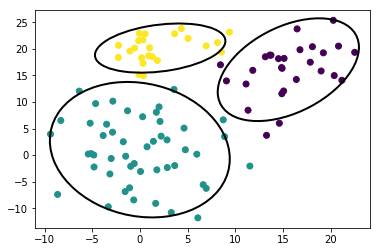

In [10]:
plot_gmm(data, gmm)

We can also visualise how the 2D feature space is partitioned into clusters.

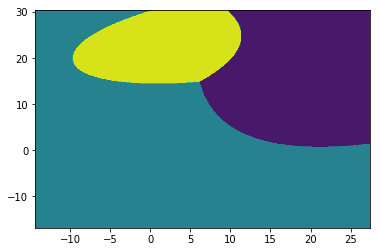

In [11]:
res = 0.1   # grid resolution
border = 5  # grid border

x0_lower = np.min(data[:,0]) - border
x0_upper = np.max(data[:,0]) + border
x1_lower = np.min(data[:,1]) - border
x1_upper = np.max(data[:,1]) + border

x0, x1 = np.mgrid[x0_lower:x0_upper:res, x1_lower:x1_upper:res]
grid = np.c_[x0.ravel(), x1.ravel()]
cluster = gmm.predict(grid).reshape(x0.shape)

plt.contourf(x0, x1, cluster)
plt.show()

Let's see what happens if we specify the "wrong" number of clusters.

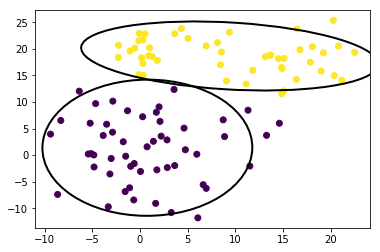

In [12]:
gmm_2 = GaussianMixture(n_components=2, covariance_type='full').fit(data)
plot_gmm(data, gmm_2)

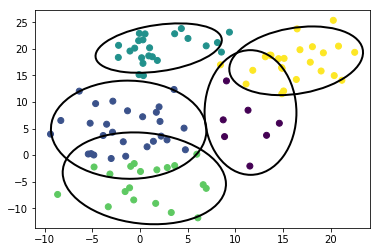

In [13]:
gmm_5 = GaussianMixture(n_components=5, covariance_type='full').fit(data)
plot_gmm(data, gmm_5)

**Exercise:** Repeat this section for different synthetic datasets, e.g. with overlapping clusters.

### 3. Tuning the number of clusters

In the previous section, we saw that it's important to select an appropriate value for $k$—i.e. GMM is not reslient to misspecified $k$.

We'll now review the following methods for selecting $k$:
1. **Log-likelihood based.** Requires held-out data. Can be computed for a data matrix `X` using `gmm.score(X)`.
2. **AIC.** Akaike information criterion. Can be computed for a data matrix `X` using `gmm.aic(X)`.
3. **BIC.** Bayesian information criterion. Can be computed for a data matrix `X` using `gmm.bic(X)`.

But first, let's generate a more complicated data set with a larger number of clusters. Note that we partition the data into train/validation so that we can apply the first method above.

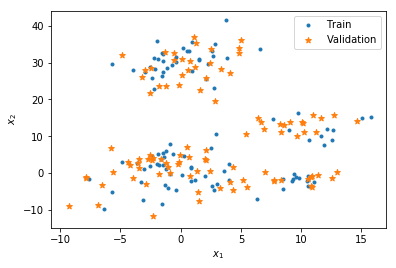

In [14]:
weights = np.array([0.3, 0.2, 0.3, 0.1, 0.1])

means = np.array([[0, 0], 
                  [50, 60], 
                  [0, 100], 
                  [100, -20], 
                  [-20, 40]])

covariances = np.array([[[160, 20], [20, 180]], 
                        [[170, 30], [30, 120]], 
                        [[130, 40], [40, 130]], 
                        [[130, 40], [40, 130]], 
                        [[130, 40], [40, 130]]])

data = generate_gmm_data(200, weights, means, covariances)

train_data, validation_data = train_test_split(data, test_size=0.5)

plt.scatter(train_data[:,0], train_data[:,1], marker='.', label='Train')
plt.scatter(validation_data[:,0], validation_data[:,1], marker='*', label='Validation')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

In the code block below, you should fit a GMM for each value of $k \in \{1,\ldots, 10\}$ and compute:
* `train_ll`: log-likelihood on the training set
* `validation_ll`: log-likelihood on the validation set
* `aic`: AIC on the training set
* `aic_corrected`: corrected AIC (defined below) on the training set
* `bic`: BIC on the training set
* `n_parameters`: number of free parameters in the model

Note that in practice it's recommended to use corrected AIC for small sample sizes. It's defined as 
$$
\mathrm{AICc} = \mathrm{AIC} + \frac{2 n_{\mathrm{par}} (n_{\mathrm{par}}+1)}{n-n_{\mathrm{par}}-1}
$$
where $n_{\mathrm{par}}$ is the number of free parameters, and $n$ is the number of data points.

In [15]:
range_k = np.arange(1, 10, dtype=int)
n_instances = data.shape[0]

# Arrays to hold quantities for each k
train_ll = np.zeros(range_k.size)
validation_ll = np.zeros(range_k.size)
aic = np.zeros(range_k.size)
aic_corrected = np.zeros(range_k.size)
bic = np.zeros(range_k.size)
n_parameters = np.zeros(range_k.size)

for i,k in enumerate(range_k):
    # your code here #

SyntaxError: unexpected EOF while parsing (<ipython-input-15-53a32e9a3bda>, line 13)

Now plot all these quantities as a function of $k$. 

**Question:** Analyse the resulting plots. What can you tell about the number of parameters? Can all of these quantities be used to estimate the number of clusters?